___

# GridSearch: PyGSP for Mouse Phenotype prediction

In [164]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,accuracy_score,f1_score,matthews_corrcoef
from pygsp import graphs, filters, plotting, learning
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import norm
from IPython.core.debugger import set_trace

import networkx as nx
import itertools
from pycm import *
import pandas as pd
import numpy as np
import scipy
import os
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

## Import Data

<div class="alert alert-block alert-info">
    
* genotype_df: contains the genotype of each strain for each allele
* phenotype_df : contains the phenotypes of each strain, lots of Nan

NB: on this branch of the project, we don't use the expression of the genes, and try instead to predict straight the phenotype from the genotype: therefore, we don't import any file from expression data.
</div>

In [165]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')
# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'
phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')
# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

### Phenotype_id_aligner

<div class="alert alert-block alert-info">
The phenotype id aligner gives us insight in the characteristics of the different genes.
</div>

In [166]:
# Phenotype id aligne is an in-depth description of each phenotype
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')
phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)
quant_pheno_best = phenotype_id_aligner[(phenotype_id_aligner.Strains > 70) & (phenotype_id_aligner.quantitative_trait == 'No')]
quant_pheno_best = quant_pheno_best.sort_values(by='Strains', ascending=False)
phenotype_id_aligner.set_index('PhenoID',inplace=True)

In [167]:
phenotype_id_aligner[phenotype_id_aligner.PhenoID == 'X62']

,PhenoID,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,quantitative_trait,Tissues,Diet,Strains
2627,X62,62,11280,"Skin, pigmentation: Hair coat color, ordinal s...","Hair coat color, ordinal scale version 2 where...",Morphology,2628.0,9.0,"Skin, pigmentation: Hair coat color, ordinal s...","Skin, pigmentation: Hair coat color, ordinal s...","Lu Lu, Jing Gu, Robert Williams",Williams,NaN,No,NaN,NaN,94


# Similarity graphs

<div class="alert alert-block alert-info">
We construct a weighted similarity graph and keep only the edges whose exponential value are above a given threshold epsilon : we can construct our graph based on 2 types of information: either genetic or expressive (protein expression). 
</div>

In [168]:
def epsilon_similarity_graph(X: np.ndarray, metric='euclidean', sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    if np.isnan(X).any():
        Dists = squareform(np.array([pdist(X[s][:, ~np.isnan(X[s]).any(axis=0)], metric) for s in map(list, itertools.combinations(range(X.shape[0]), 2))]).ravel())
        Dists[Dists == 0] = 1E8
        Dists = np.nan_to_num(Dists,nan = 1E8)
    else:
        Dists = squareform(pdist(X,metric = metric))

    Dists = np.exp(-Dists**2/(2 * sigma**2))
    Dists[Dists <= epsilon] = 0
    np.fill_diagonal(Dists,0)
    return Dists

In [169]:
def plot_distrib(adjacency):
    """ Plot the density of kerneled distances
    adjacency : adjacency matrix
    """
    non_zero = adjacency[np.nonzero(adjacency)]
    print("{:0.2f} % of the original data is kept".format(non_zero.size / adjacency.size * 100))
    plt.plot(np.sort(non_zero)[::-1])

## Genotype similarity graph

<div class="alert alert-block alert-info">
We use the gene presence/absence according to different genes couples with a metric such as the cosine or jaccard distance in order to build the graph.
</div>

59.22 % of the original data is kept


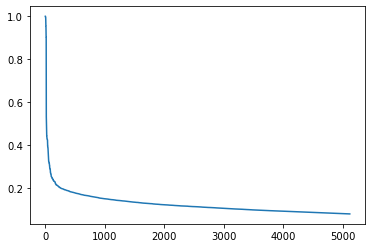

In [253]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 0.45,epsilon = 0.08,metric = 'cosine')
plot_distrib(k)

40.31 % of the original data is kept


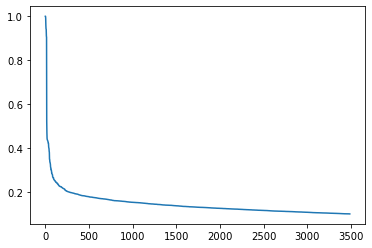

In [244]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 0.23,epsilon = 0.1,metric = 'hamming')
plot_distrib(k)

98.81 % of the original data is kept


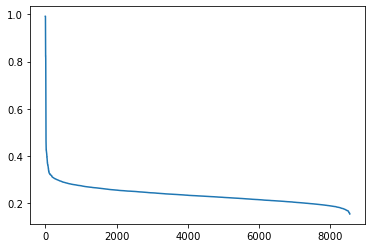

In [257]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 70,epsilon = 0.15,metric = 'euclidean')
plot_distrib(k)

## Expression Similarity Graph

<div class="alert alert-block alert-info">
In order to deal with missing values, we compute the distance according to the given criteria (minkowsky,l2 etc) only on the common features. If 2 samples don't share any feature, then they are considered disconnected.
</div>

In [173]:
with open('data/pickle/concat_expression.pkl','rb') as f:
    expr_df = pickle.load(f)
expr_df['nancount'] = expr_df.isnull().sum(axis = 1)
if False:
    expr_df = expr_df[expr_df.nancount == expr_df.nancount.min()].drop(columns = ['nancount'])
else:
    expr_df = expr_df.sort_values(by = 'nancount').head(100000).drop(columns = ['nancount'])
#remove the mouses which don't have information in this top
expr_df = expr_df.T[~expr_df.isna().all()]

46.04 % of the original data is kept


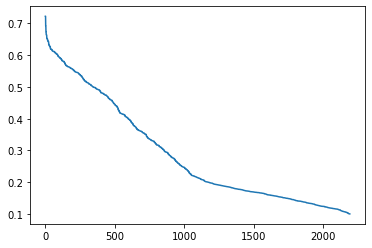

In [174]:
m = epsilon_similarity_graph(expr_df.values,sigma = 42,epsilon = 0.1,metric = 'euclidean')
plot_distrib(m)

49.57 % of the original data is kept


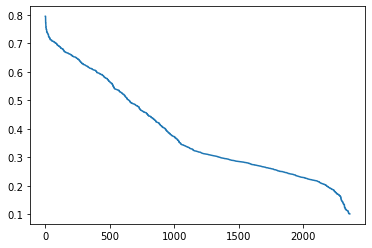

In [175]:
#Same is done with L1 distance
m = epsilon_similarity_graph(expr_df.values,sigma = 50,epsilon = 0.1,metric = 'minkowski')
plot_distrib(m)

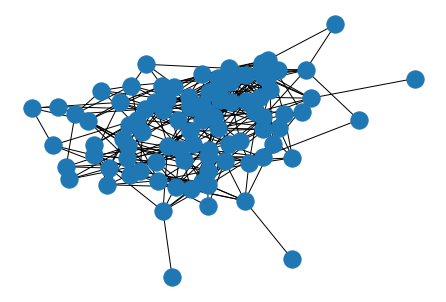

In [456]:
m = epsilon_similarity_graph(expr_df.values,sigma = 50,epsilon = 0.1,metric = 'minkowski')
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
netx_weighted_graph = pygsp_weighted_graph.to_networkx()
nx.draw(netx_weighted_graph)

In [522]:
netx_weighted_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92))

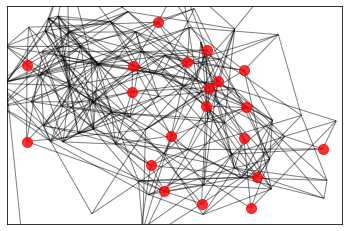

In [527]:

pos=nx.spring_layout(netx_weighted_graph)
nx.draw_networkx_nodes(netx_weighted_graph,pos,
                       nodelist=list(np.arange(20)),
                       node_color='r',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(netx_weighted_graph,pos,width=1.0,alpha=0.5)

# Exploitation

<div class="alert alert-block alert-info">
At that point, all we need is a pygsp graph describing the different strains created from an adjacency matrix: the way it is linked is therefore critical for the success of the algorithm.
</div>

In [176]:
def get_min_max(params_scores):
    """
    params_scores: list of list with each row having the following information
    f1,acc,met,sig,eps,tau
    """
    #we sort according to the first metric written in the array
    sorto = lambda x: x[0]
    mino = min(params_scores,key = sorto)[0]
    maxo = max(params_scores,key = sorto)[0]
    return mino,maxo

In [259]:
dic_disc_gen = {}
for i,phen in enumerate(top_disc):
    try:
        print('#'*20 + "%i/%i phenotype" % (i,len(top_disc))+ '#'*20)
        result = np.nan
        result = grid_search_graphs(genotype_df,CV_discrete,METRICS,SIGMAS,EPSILONS,TAUS,phen)
        dic_disc_gen[phen] = result
        with open('results/dic_disc_gen.pickle','wb') as f:
            pickle.dump(dic_disc_gen,f)
    except Exception as e:
        print('ERROR')
        print(e.__doc__,str(e))
        continue

####################0/10 phenotype####################
 880 / 3000 combinations
 890 / 3000 combinations
 900 / 3000 combinations
 910 / 3000 combinations
 920 / 3000 combinations


KeyboardInterrupt: 

In [293]:
def grid_search_graphs(bio_df,CV_meth,metrics,sigmas,epsilons,taus,phenotypes,file_name):
    """
    grid_search_graphs performs a grid search over the parameters:
    metric,sigmas,epsilons and taus. A CV is done for each combination of parameters, and gets stored in
    the list params_scores.
    
    bio_df :         genotype_df or expr_df
    CV_meth:         a method performing cross validation (on discrete or continuous variable)
    metrics:         list of metrics usable in a pdist matrix
    sigmas,epsilons: parameter for the adjacency matrix we do the grid search on
    phenotypes:      list of phenotypes we want to be able to predict
    """
    params_scores = {phen:[] for phen in phenotypes}
    for i,met in enumerate(metrics):
        for j,sig in enumerate(sigmas[met]):
            for k,eps in enumerate(epsilons[met]):
                tot_comb = len(metrics) * len(sigmas[met]) * len(epsilons[met]) * len(taus)
                for l,tau in enumerate(taus):
                    ind = l + len(taus) * (k + len(epsilons[met]) * (j + len(sigmas[met]) * (i)))
                    print("%i / %i combinations" % (ind+1,tot_comb))
                    try:
                        weighted_adjacency = epsilon_similarity_graph(bio_df.values, metric=met, sigma=sig, epsilon=eps)
                        for ind_phen,phen in enumerate(phenotypes):
                            #print("%i/%i phenotype" % (ind_phen,len(phenotypes)))
                            try:
                                pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
                                #met1 = MCC/R2 // met2 = acc/MSE
                                met1,met2 = CV_meth(pygsp_weighted_graph,phenotype_df.loc[phen],bio_df,tau)
                                params_scores[phen].append([met1,met2,met,sig,eps,tau])
                                #we save it in case it crashes
                                with open('results/' + file_name + '.pickle','wb') as f:
                                    pickle.dump(params_scores,f)
                                mino,maxo = get_min_max(params_scores[phen])
                                #print('Biggest result for phenotype {a} : {b:.2f} \nSmallest result for phenotype {c} : {d:.2f}'.format(a =phen,b=maxo,c=phen,d=mino))
                            #we don't want the gridsearch to stop in case of an error
                            except Exception as e:
                                print('ERROR')
                                print(e.__doc__,str(e))
                                continue
                    except nx.NetworkXError:
                        print('non connected graph with %.2f sigma and %.2f epsilon' % (sig,eps))
                        continue
    
    return params_scores
    

## Cross Validation

In [475]:
k = np.array([1,2,2])
np.where(k==2)

(array([1, 2]),)

In [583]:
def CV_discrete(pygsp_weighted_graph,gene_serie,bio_df,tau,NUM_REPET = 50,plot = False):
    """
    CV_discrets performs a cross_validation by taking a random subset repr 20% (test set)of the graph defined above, training a tikhonov classifier
    on the training set( 80%) and return the MCC and the accuracy for the  given parameters.
    pygsp_weighted_graph: the graph built thanks to the adjacency matrix
    bio_df: either genotype_df or expr_df
    tau: regularization parameter for tikhonov
    """
    y_true = gene_serie[bio_df.index]
    nan_present = y_true.isnull().any()
    
    #we keep trace of the mapping
    mapping = dict(zip(y_true.astype('category').cat.codes + 1, y_true))
    
    if nan_present:
        nan_indxes = np.where(np.isnan(y_true))[0]
        y_true = y_true.astype('category').cat.codes
        y_true = y_true + 1
        assert(y_true[nan_indxes][0] == 0)
    else:
        y_true = y_true.astype('category').cat.codes
        y_true = y_true + 1
    
    met,acc = 0,0
    for i in range(NUM_REPET):
        rs = np.random.RandomState()
        train_mask = rs.uniform(0,1,pygsp_weighted_graph.N) > 0.2
        #we make sure that the nan always end up in the train
        if nan_present:
            train_mask[nan_indxes] = True
        labels_true = y_true[~train_mask]
        y_sparse = y_true.copy()
        y_sparse[~train_mask] = np.nan

        recovery = learning.classification_tikhonov(pygsp_weighted_graph,y_sparse,train_mask,tau=tau)
        
        #we get rid of the 0 value: we don't accept no label
        #if nan_present:
        #    recovery[:,0] = -1
        prediction = np.argmax(recovery, axis=1)
        
        labels_pred = prediction[~train_mask]
        met += matthews_corrcoef(labels_true,labels_pred)
        acc += accuracy_score(labels_true,labels_pred)
    #set_trace()
    met_final = met/NUM_REPET
    acc_final = acc/NUM_REPET
    if plot:
        print('Used mapping: \t',mapping)
        #useful to chose metrics
        cm = ConfusionMatrix(actual_vector=labels_true.values, predict_vector=labels_pred)
        print('MCC:%.2f \nAccuracy:%.2f'% (met_final,acc_final))
        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
        limits = [min(y_true.unique().min(),0),y_true.unique().max()+ 1]

        #ground truth
        pygsp_weighted_graph.plot_signal(y_true, ax=ax[0], title='Ground truth',limits = limits)
        #measurements
        pygsp_weighted_graph.plot_signal(y_sparse, ax=ax[1], title='Measurements',limits = limits)
        #recover
        prediction = [limits[1] + 1 if i == j and not k else i for i,j,k in zip(prediction,y_true,train_mask)]
        pygsp_weighted_graph.plot_signal(prediction, ax=ax[2], title='Recovered class',limits = limits)
        
        
    return met_final,acc_final

In [179]:
def CV_continuous(pygsp_weighted_graph,gene_serie,bio_df,tau,NUM_REPET = 50,metric_meth = mean_squared_error,plot = False):
    """
    equivalent
    """
    ycont_true = gene_serie[bio_df.index]
    ycont_true.fillna(ycont_true.mean(),inplace = True)
    #mae or mse
    mxe = 0
    r2 = 0
    for i in range(NUM_REPET):
        mask = np.random.RandomState().uniform(0,1,pygsp_weighted_graph.N) > 0.2
        vals_true = ycont_true[~mask]
        ycont_sparse = ycont_true.copy()
        ycont_sparse[~mask] = np.nan

        recovery = learning.regression_tikhonov(pygsp_weighted_graph,ycont_sparse,mask,tau=tau)
        if any(np.isnan(recovery)):
            return np.nan
        vals_pred = recovery[~mask]
        mxe += metric_meth(vals_true,vals_pred)
        r2 += r2_score(vals_true,vals_pred)

    mxe_avg = mxe / NUM_REPET
    r2_avg = r2 / NUM_REPET
    if plot:
        print(str(metric_meth)+ "%.2f \nr2: %.2f" % (mxe_avg,r2_avg))
        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
        limits = [ycont_true.min(),ycont_true.max()]

        #ground truth
        pygsp_weighted_graph.plot(ycont_true, ax=ax[0],limits = limits, title='Ground truth')
        #measurements
        pygsp_weighted_graph.plot_signal(ycont_sparse, ax=ax[1],limits = limits, title='Measurements')
        #recover
        pygsp_weighted_graph.plot_signal(recovery, ax=ax[2],limits = limits, title='Recovered class')
    return r2_avg,mxe_avg

# Instanciations

In [180]:
top_variables = phenotype_df.join(phenotype_id_aligner.set_index('PhenoID')[['quantitative_trait']],how = 'inner').copy()
top_variables['nan_count'] = top_variables.isnull().sum(axis = 1)

top_continuous = top_variables[top_variables.quantitative_trait == 'Yes']\
                                            .sort_values('nan_count')\
                                            .head(30)\
                                            .drop(columns = ['nan_count','quantitative_trait'])\
                                            .copy()

top_discrete = top_variables[top_variables.quantitative_trait == 'No']\
                                          .sort_values('nan_count')\
                                          .head(30)\
                                          .drop(columns = ['nan_count','quantitative_trait'])\
                                          .copy()

top_discrete = top_discrete[top_discrete.T.nunique() <10]
top_discrete.drop('X57',inplace = True)
"""top_discrete = top_discrete.astype('category')
catcols = top_discrete.select_dtypes(['category']).columns
top_discrete[catcols] = top_discrete[catcols].apply(lambda x: x.cat.codes)"""

top_discrete = top_discrete.T
top_continuous = top_continuous.T

print('The most present continuous variables are : {} \n'.format(' '.join(top_continuous.columns.values)))
print('The most present discrete variables are : {}'.format(' '.join(top_discrete.columns.values)))


top_disc = top_discrete.columns.values
top_cont = top_continuous.columns.values

The most present continuous variables are : X3820 X2397 X1002 X328 X218 X416 X699 X1302 X2147 X2164 X885 X1206 X2334 X2230 X1646 X1977 X424 X2041 X4482 X332 X228 X3903 X4556 X4256 X4849 X5029 X2490 X457 X2645 X2689 

The most present discrete variables are : X546 X152 X111 X1012 X4473 X64 X62 X63 X76 X61


## Visual instantiation

<div class="alert alert-block alert-info">
We do an example of genetic based network with fixed parameters and see how the algorithm performs visually.    
    
* The purple data points in the ground truth plot represent the missing values (nan)
* The purple data points in the measurement graph represent both the test set and missing values( despite the fact that the test set never gets mixed up with these missing values)
* The yellow points describe the points classified correctly by the classifier
</div>

Used mapping: 	 {1: 1.0, 4: 4.0, 3: 3.0, 2: 2.0, 0: nan}
MCC:0.46 
Accuracy:0.57


(0.4608495170847641, 0.5714285714285714)

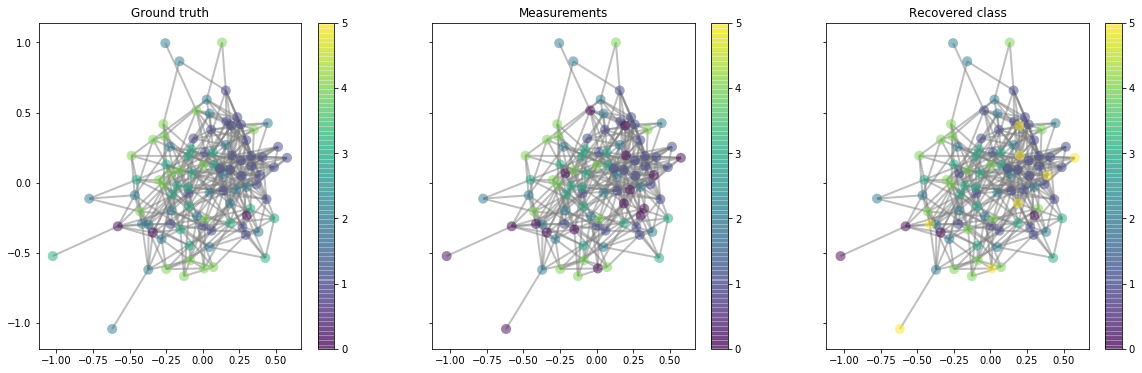

In [584]:
weighted_adjacency = epsilon_similarity_graph(genotype_df.values, metric='cosine', sigma=0.4, epsilon=0.1)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,top_discrete['X62'],genotype_df,0,1,True)


## Grid Searches

In [317]:
N_SIGMA = 1#20
N_EPS = 1#10
N_TAU = 1#5

In [318]:
def get_top_phen(n,dico):
    """
    return the n first top phenotypes with best score according to one of the dictionnary obtained by gridsearch/cv
    """
    maxo = lambda x: max(x,key = lambda x:x[0])
    maxvec = [(key,maxo(val)) for key,val in dico.items()]
    return sorted(maxvec,key = lambda x: x[1],reverse = True)[:n]

### Genetic based

In [325]:
#real parameters for genetic
METRICS = ['cosine','hamming','euclidean']

SIGMAS = {'cosine':np.linspace(0.3,0.6,N_SIGMA),\
          'hamming':np.linspace(0.18,0.29,N_SIGMA),\
          'euclidean':np.linspace(65,75,N_SIGMA)}

EPSILONS = {'cosine':np.linspace(0.06,0.14,N_EPS),\
            'hamming':np.arange(0.03,0.16,N_EPS),\
            'euclidean':np.linspace(0.15,0.32,N_EPS)}

TAUS = np.logspace(0,np.log10(10),N_TAU)

#### Discrete features, genetic based

In [326]:
# 2 hours
dic_disc_gen = grid_search_graphs(genotype_df,CV_discrete,METRICS,SIGMAS,EPSILONS,TAUS,top_disc,'dic_disc_gen')

0 / 3 combinations
1 / 3 combinations
2 / 3 combinations


In [327]:
with open('results/dic_disc_gen.pickle','rb') as f:
    dic_disc_gen = pickle.load(f)
get_top_phen(5,dic_disc_gen)

[('X111',
  [0.4702084701031307, 0.7386856776881007, 'hamming', 0.18, 0.03, 1.0]),
 ('X64', [0.29067452765718554, 0.3185593747311004, 'cosine', 0.3, 0.06, 1.0]),
 ('X62', [0.2766657765934517, 0.3023203711119649, 'cosine', 0.3, 0.06, 1.0]),
 ('X63',
  [0.2708903990855848, 0.44618158958718246, 'hamming', 0.18, 0.03, 1.0]),
 ('X152', [0.23743931342493443, 0.3720091841169106, 'cosine', 0.3, 0.06, 1.0])]

#### Continuous features, genetic based

In [328]:
#3 hours
dic_cont_gen = grid_search_graphs(genotype_df,CV_continuous,METRICS,SIGMAS,EPSILONS,TAUS,top_cont,'dic_cont_gen')

0 / 3 combinations
1 / 3 combinations
2 / 3 combinations


In [330]:
with open('results/dic_cont_gen.pickle','rb') as f:
    dic_cont_gen = pickle.load(f)
get_top_phen(5,dic_cont_gen)

[('X332',
  [-0.01868666147484117, 2900.2592053791996, 'euclidean', 65.0, 0.15, 1.0]),
 ('X3820',
  [-0.019239978604254186, 0.4826610159240375, 'hamming', 0.18, 0.03, 1.0]),
 ('X4256',
  [-0.01976806462103966, 64.19024619143606, 'euclidean', 65.0, 0.15, 1.0]),
 ('X4849',
  [-0.033274172243531026, 60.237654689265575, 'euclidean', 65.0, 0.15, 1.0]),
 ('X3903',
  [-0.048064775118813116, 51.20755836113595, 'euclidean', 65.0, 0.15, 1.0])]

### Expression based

In [ ]:
#real params for expression
METRICS_E = ['euclidean','minkowski']

SIGMAS_E = {'euclidean':np.logspace(np.log10(42),np.log10(4000),N_SIGMA),\
            'minkowski':np.logspace(np.log10(50),np.log10(2000),N_SIGMA)}

EPSILONS_E = {'euclidean':np.linspace(0.1,0.6,N_EPS),\
              'minkowski':np.linspace(0.1,0.6,N_EPS)}

TAUS_E = np.logspace(0,np.log10(10),N_TAU)

#### Discrete features, expression based

In [ ]:
#2hours
dic_disc_exp = grid_search_graphs(expr_df,CV_discrete,METRICS_E,SIGMAS_E,EPSILONS_E,TAUS_E,top_disc,'dic_disc_exp')

In [ ]:
with open('results/dic_disc_exp.pickle','rb') as f:
    dic_disc_exp = pickle.load(f)
get_top_phen(5,dic_disc_exp)

#### Continuous features, expression based

In [ ]:
#3 hours
dic_cont_exp = grid_search_graphs(genotype_df,CV_continuous,METRICS_E,SIGMAS_E,EPSILONS_E,TAUS_E,top_cont,'dic_cont_exp')

In [ ]:
with open('results/dic_cont_exp.pickle','rb') as f:
    dic_cont_exp = pickle.load(f)
get_top_phen(5,dic_cont_exp)

# PostAnalysis of the best genes

In [346]:
with open('results/dic_cont_gen.pickle','rb') as f:
    dic_cont_gen = pickle.load(f)
with open('results/dic_disc_genzone71.pickle','rb') as f:
    dic_disc_gen = pickle.load(f)
with open('results/dic_cont_exp.pickle','rb') as f:
    dic_cont_exp = pickle.load(f)
with open('results/dic_disc_expzone71.pickle','rb') as f:
    dic_disc_exp = pickle.load(f)

<div class="alert alert-block alert-info">
We now check which genes gave the best results with the grid search.
</div>

In [347]:
get_top_phen(10,dic_disc_gen)

[('X111',
  [0.5410516604131521,
   0.7730409980441482,
   'cosine',
   74,
   0.32000000000000006,
   1.0]),
 ('X63',
  [0.3698917898038755,
   0.5251597237870288,
   'jaccard',
   74,
   0.32000000000000006,
   1.0]),
 ('X64',
  [0.34802595928441477,
   0.5099052168999999,
   'hamming',
   74,
   0.32000000000000006,
   1.0]),
 ('X152',
  [0.32640440545691113, 0.5985588464951841, 'euclidian', 60, 0.2, 1.0]),
 ('X62',
  [0.30740043495327485,
   0.40658101469107677,
   'euclidian',
   74,
   0.36000000000000004,
   3.1622776601683795]),
 ('X546',
  [0.2424301294497391,
   0.4044930333129737,
   'jaccard',
   60,
   0.24000000000000002,
   1.0]),
 ('X4473',
  [0.20846622106284746, 0.22162444408614818, 'hamming', 60, 0.28, 1.0]),
 ('X1012',
  [0.1971910831814439,
   0.3950213357916818,
   'cosine',
   60,
   0.24000000000000002,
   1.0]),
 ('X76',
  [0.14231903982852703,
   0.5012688553276787,
   'cosine',
   74,
   0.36000000000000004,
   1.0]),
 ('X61',
  [0.13741549505862294,
   nan,


In [348]:
get_top_phen(5,dic_cont_gen)

[('X424', [-0.17810222197373762, 2.1489556683640982, 'cosine', 0.4, 0.1, 0]),
 ('X2334', [-0.22938685758953967, 27.104068881206018, 'cosine', 0.4, 0.1, 0]),
 ('X1646', [-0.23434463069151237, 0.33646870635874765, 'cosine', 0.4, 0.1, 0]),
 ('X4849', [-0.34499617387055076, 75.68751658784558, 'cosine', 0.4, 0.1, 0]),
 ('X1206', [-0.4111487969094827, 1.4761504504803822, 'cosine', 0.4, 0.1, 0])]

In [349]:
get_top_phen(10,dic_disc_exp)

[('X111', [1.0, 1.0, 'euclidean', 60, 0.2, 1.0]),
 ('X152', [0.860330516149773, 0.914933017618776, 'minkowski', 70, 0.2, 1.0]),
 ('X546', [0.8352272226532297, 0.9158424056163993, 'euclidean', 72, 0.2, 1.0]),
 ('X1012',
  [0.7841014655874919, 0.8891426837696186, 'minkowski', 60, 0.2, 10.0]),
 ('X63', [0.3023002680723459, 0.4561011123566313, 'minkowski', 62, 0.2, 10.0]),
 ('X62',
  [0.29781129226655556, 0.46388445614599866, 'minkowski', 70, 0.2, 1.0]),
 ('X64', [0.2937852881037846, 0.4571250728975187, 'euclidean', 66, 0.2, 1.0]),
 ('X61', [0.0225, nan, 'minkowski', 66, 0.2, 1.0]),
 ('X4473', [0.0, 0.9103490431137489, 'euclidean', 60, 0.2, 1.0]),
 ('X76', [0.0, 0.8353162610523291, 'euclidean', 60, 0.2, 1.0])]

In [34]:
get_top_phen(5,dic_disc_gen)

[('X111',
  [0.5410516604131521,
   0.7730409980441482,
   'cosine',
   74,
   0.32000000000000006,
   1.0]),
 ('X63',
  [0.3698917898038755,
   0.5251597237870288,
   'jaccard',
   74,
   0.32000000000000006,
   1.0]),
 ('X64',
  [0.34802595928441477,
   0.5099052168999999,
   'hamming',
   74,
   0.32000000000000006,
   1.0]),
 ('X152',
  [0.32640440545691113, 0.5985588464951841, 'euclidian', 60, 0.2, 1.0]),
 ('X62',
  [0.30740043495327485,
   0.40658101469107677,
   'euclidian',
   74,
   0.36000000000000004,
   3.1622776601683795])]

<div class="alert alert-block alert-info">
And reproduce the result in the following subsections.
</div>

## Genetics,statistics and cofactors

MCC:1.00 
Accuracy:1.00


(1.0, 1.0)

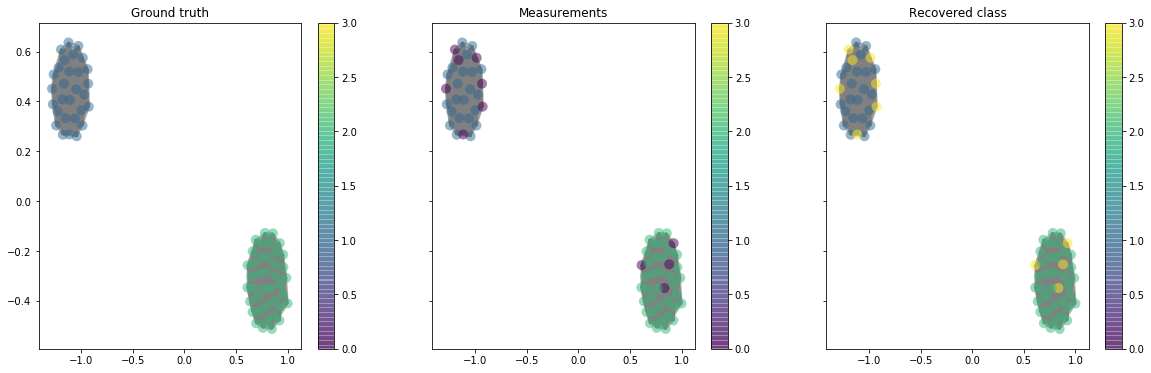

In [355]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='euclidean', sigma=60, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X111'],expr_df,1,NUM_REPET=15,plot = True)

MCC:0.86 
Accuracy:0.92


(0.8585016417913113, 0.9214888814888816)

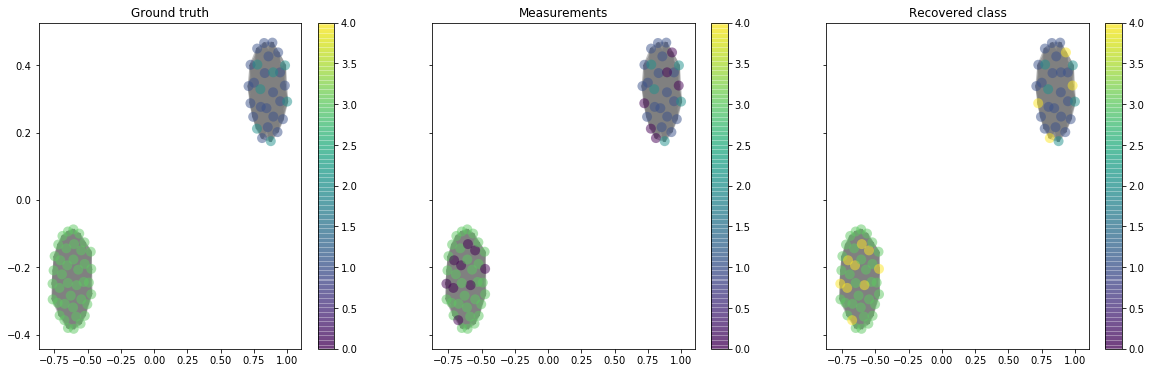

In [354]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='minkowski', sigma=70, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X152'],expr_df,1,NUM_REPET=15,plot = True)

MCC:0.73 
Accuracy:0.85


(0.727527975237784, 0.8505163435598218)

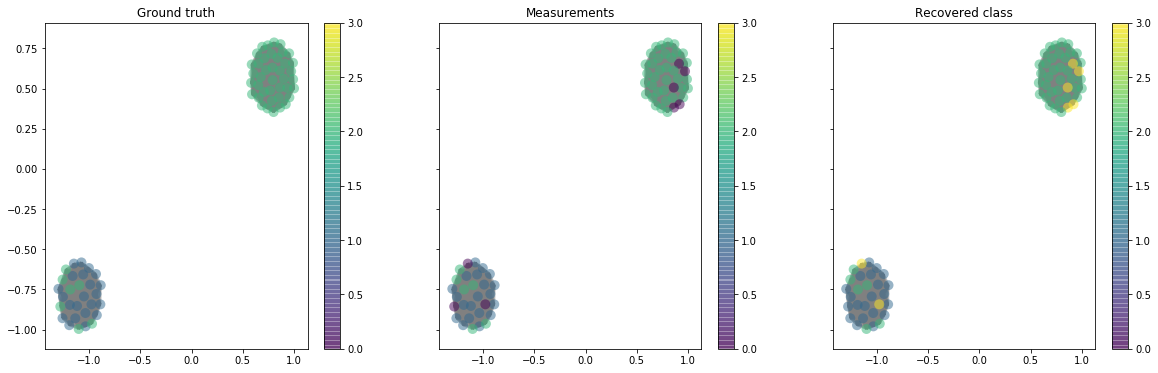

In [356]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='euclidean', sigma=72, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X546'],expr_df,1,NUM_REPET=15,plot = True)

MCC:0.23 
Accuracy:0.42


(0.23241108920882783, 0.42367174693261656)

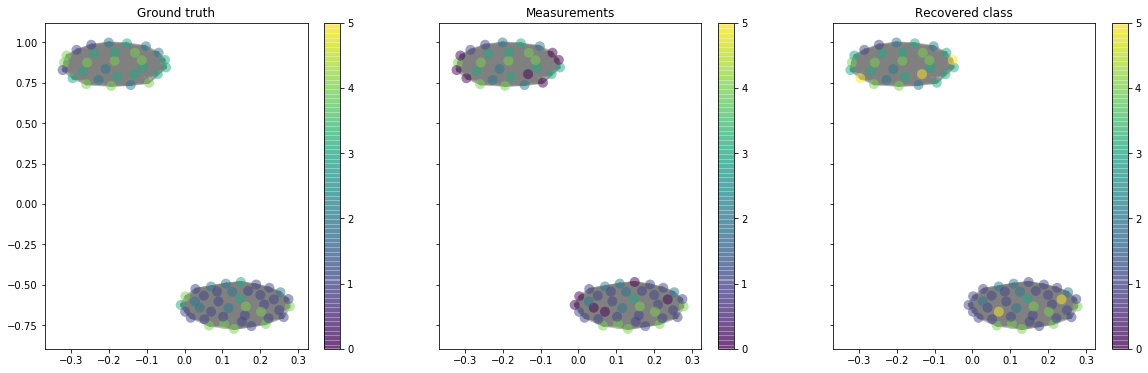

In [361]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='minkowski', sigma=70, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X62'],expr_df,1,NUM_REPET=15,plot = True)

<div class="alert alert-block alert-info">
We see that the features X111 X152 X546 X1012 obtained an unusually high accuracy compared to others. The first potential explanation would be the sex of the mouses
</div>

In [413]:
male = pd.read_csv('./data/expression_data/Adrenal_Male.txt', sep='\t', index_col=None, header=0)
male.drop(columns = ['gene'],inplace = True)
female = pd.read_csv('./data/expression_data/Adrenal_Male.txt', sep='\t', index_col=None, header=0)
female.drop(columns = ['gene'],inplace = True)

dic_m = dict(np.array([male.columns.values,[0]* male.columns.shape[0]]).T)
dic_f = dict(np.array([female.columns.values,[1]* female.columns.shape[0]]).T)
dico = {**dic_m, **dic_f}

In [430]:
dic_m.keys() == dic_f.keys()

True

<div class="alert alert-block alert-info">
So the strains don't have any specific sex. Let's take a closer look at the concerned genes.
</div>

In [431]:
print(phenotype_id_aligner.loc['X111'].Phenotype)
print(phenotype_id_aligner.loc['X152'].Phenotype)
print(phenotype_id_aligner.loc['X546'].Phenotype)
print(phenotype_id_aligner.loc['X1012'].Phenotype)

Genetics, statistics, cofactors: BXD epoch or phase of production trait 2 [-1 = Taylor BXD series BXD1 to 42, 1 = UTHSC BXD series BXD43 and higher]
Genetics, statistics, cofactors: BXD epoch or phase of production trait 1 [-1 = Taylor BXD series BXD1 to 32, 0 = Taylor series BXD33 to 42, 1 = UTHSC BXD series BXD43 and higher]
Genetics, statistics, cofactors: BXD epoch or phase of production trait 3 [-1 = Taylor BXD series BXD1 to 32, 1 = Taylor series BXD33 to 42 and all UTHSC BXD series BXD43 and higher]
Genetics, statistics, cofactors: BXD epoch or phase of production trait 4 [-1 = Taylor BXD series BXD1 to 30, 0 = BXD31 and higher]


<div class="alert alert-block alert-info">
It looks that somehow, all these genes are related. We then show that it is not due to chance, as only one other gene is part of theses serie of Genetics,statistics and cofactors.
</div>

In [429]:
phenotype_id_aligner[phenotype_id_aligner.Phenotype.str.contains('BXD epoch')]

,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,quantitative_trait,Tissues,Diet,Strains
PhenoID,,,,,,,,,,,,,,,,
X2164,2164,11018,"Central nervous system, morphology: Forebrain ...","Forebrain weight, adjusted by age, sex, body w...",Morphology,2616.0,9.0,"Central nervous system, morphology: Forebrain ...","Central nervous system, morphology: Forebrain ...","Kim Acklin, Lu Lu, Robert Williams",Williams,NaN,Yes,brain,NaN,83
X152,152,12688,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 1 [-1 =...,Other,4742.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...",Williams RW,Williams,NaN,No,NaN,NaN,93
X111,111,12689,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 2 [-1 =...,Other,4743.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...",Williams RW,Williams,NaN,No,NaN,NaN,93
X546,546,12690,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 3 [-1 =...,Other,4744.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...","Williams RW, Lu L",Williams,NaN,No,NaN,NaN,93
X1012,1012,13033,"Genetics, statistics, cofactors: BXD epoch or ...",BXD epoch or phase of production trait 4 [-1 =...,Other,4745.0,12.0,"Genetics, statistics, cofactors: BXD epoch or ...","Genetics, statistics, cofactors: BXD epoch or ...","Williams RW, Lu L",Williams,NaN,No,NaN,NaN,92


<div class="alert alert-block alert-info">
A deeper look of the phenotype could be useful, the concerned person was thus contacted for more information.
</div>

## Color

Used mapping: 	 {1: 1.0, 4: 4.0, 3: 3.0, 2: 2.0}
MCC:0.25 
Accuracy:0.44


(0.25494710616153843, 0.4416391388109653)

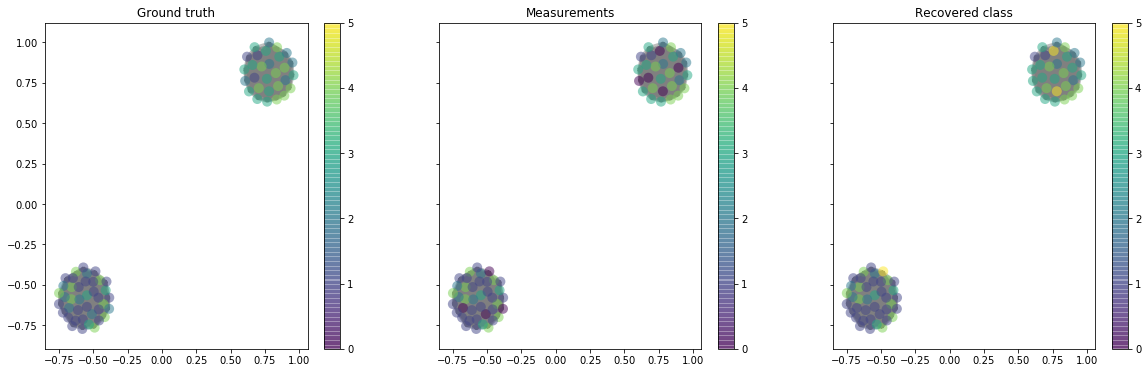

In [585]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='minkowski', sigma=60, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X62'],expr_df,1,NUM_REPET=50,plot = True)

MCC:0.30 
Accuracy:0.48


(0.3036557449804367, 0.4823669123274385)

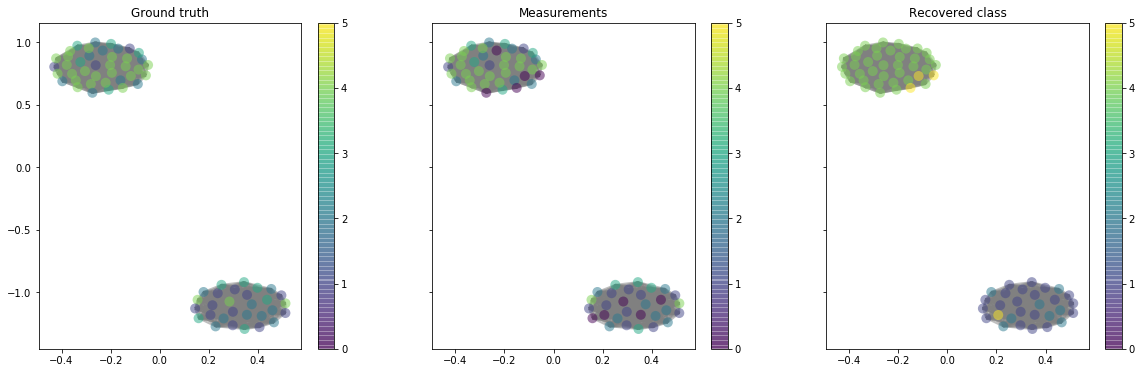

In [441]:
weighted_adjacency = epsilon_similarity_graph(expr_df.values, metric='minkowski', sigma=70, epsilon=0.2)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X63'],expr_df,10,NUM_REPET=50,plot = True)

<div class="alert alert-block alert-info">
Let's take a look at the corresponding phenotypes:
</div>

In [587]:
phenotype_df.shape

(5092, 93)

In [439]:
print(phenotype_id_aligner.loc['X62'].Phenotype)
print(phenotype_id_aligner.loc['X63'].Phenotype)

Skin, pigmentation: Hair coat color, ordinal scale version 2 where black=4, grey=3, brown=2, dba dilute=1 [color intensity]
Skin, pigmentation: Hair coat color, ordinal scale version 3 where grey=1, black=2, brown=3, dba dilute=4 [color intensity]


<div class="alert alert-block alert-info">
It seems like we already manage to separate decently the mouses according to their genes: however, the graphs look too connected. We will see in the following sections how to improve the performance.
</div>